In [1]:
from tqdm import tqdm
from analysis.nlp_transformations import separate_previous_conversation, remove_footers
from typing import List
from dao.email import DAOEmailGenerated, DAORealEmail

from dao.attribute import DAOAttribute
from analysis.nlp_transformations import replace_links_with_text

[nltk_data] Downloading package stopwords to /home/pawel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/pawel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package pl196x to /home/pawel/nltk_data...
[nltk_data]   Package pl196x is already up-to-date!
[nltk_data] Downloading package wordnet to /home/pawel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from models.email import EmailGeneratedInDB
from analysis.attribute_retriving import calculate_burstiness
from analysis.nlp_transformations import lemmatize_text
from models.attribute import AttributeInDB

dao_generated_emails: DAOEmailGenerated = DAOEmailGenerated()
dao_real_emails: DAORealEmail = DAORealEmail()
dao_attribute: DAOAttribute = DAOAttribute()


all_attributes: List[AttributeInDB] = dao_attribute.find_many_by_query({'burstiness': None})
all_generated: List[AttributeInDB] = [attribute for attribute in all_attributes if attribute.referenced_db_name == 'email_generated_dataset']
all_real: List[AttributeInDB] = [attribute for attribute in all_attributes if attribute.referenced_db_name != 'email_generated_dataset']

generated_personal_emails: List[EmailGeneratedInDB] = dao_generated_emails.find_many_by_query({'possible_advertisement': {'$ne': True}})
real_personal_emails = [dao_real_emails.find_one(generated_email.og_db_name, generated_email.og_doc_id) for generated_email in generated_personal_emails]

generated_personal: List[AttributeInDB] = [dao_attribute.find_one_by_query({'referenced_doc_id': email.id}) for email in generated_personal_emails]
real_personal: List[AttributeInDB] = [dao_attribute.find_one_by_query({'referenced_doc_id': email.id}) for email in real_personal_emails]

In [3]:
generated_personal = [attribute for attribute in generated_personal if attribute is not None]
real_personal = [attribute for attribute in real_personal if attribute is not None]

In [4]:
pl_generated_personal = [attribute for attribute in generated_personal if attribute.language == 'pl']
pl_real_personal = [attribute for attribute in real_personal if attribute.language == 'pl']
en_generated_personal = [attribute for attribute in generated_personal if attribute.language == 'en']
en_real_personal = [attribute for attribute in real_personal if attribute.language == 'en']

In [5]:
from matplotlib import pyplot as plt
import numpy as np


def hist_attribute(data, title, num_bin = 10, max_value=5, min_value=0, metric_name="Metric"):
    data_to_plot = []
    for d in data:
        if d<max_value:
            data_to_plot.append(d)
        else:
            data_to_plot.append(max_value)

    w = (max_value-min_value)/num_bin
    plt.hist(data_to_plot, bins=np.arange(min_value, max_value + w, w))
    plt.title(title)
    plt.xlim([min_value, max_value])
    plt.xlabel(f'{metric_name} value')
    plt.ylabel('Number of emails')
    plt.show()

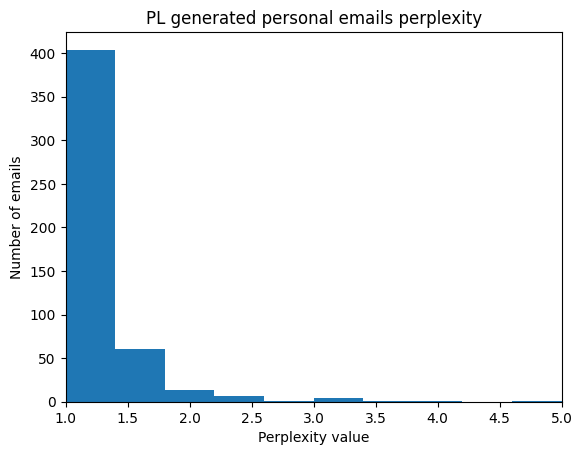

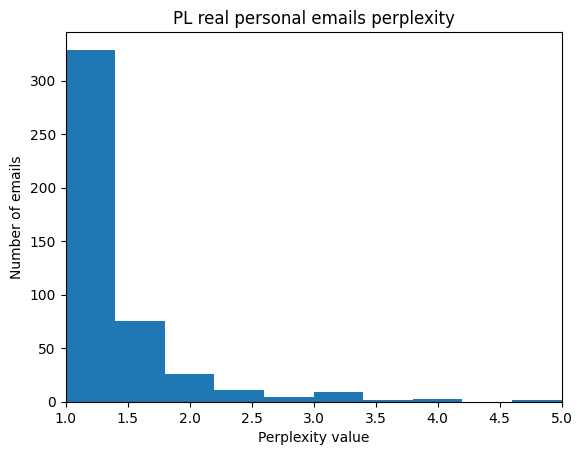

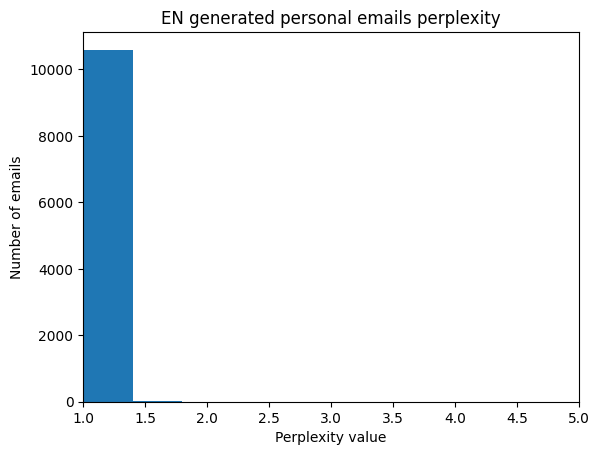

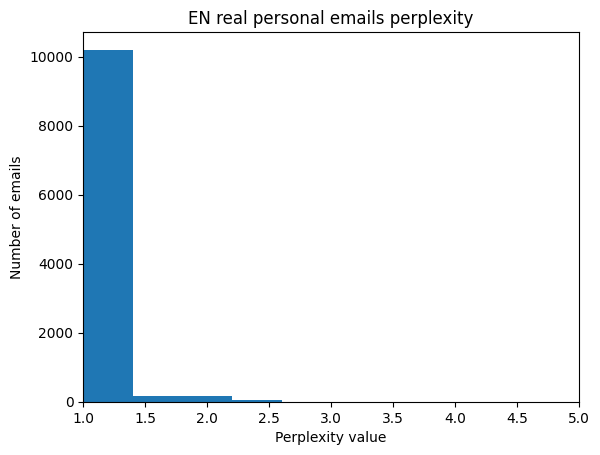

In [22]:
hist_attribute([attribute.perplexity for attribute in pl_generated_personal], 'PL generated personal emails perplexity', min_value=1, metric_name="Perplexity")
hist_attribute([attribute.perplexity for attribute in pl_real_personal], 'PL real personal emails perplexity', min_value=1, metric_name="Perplexity")
hist_attribute([attribute.perplexity for attribute in en_generated_personal], 'EN generated personal emails perplexity', min_value=1, metric_name="Perplexity")
hist_attribute([attribute.perplexity for attribute in en_real_personal], 'EN real personal emails perplexity', min_value=1, metric_name="Perplexity")

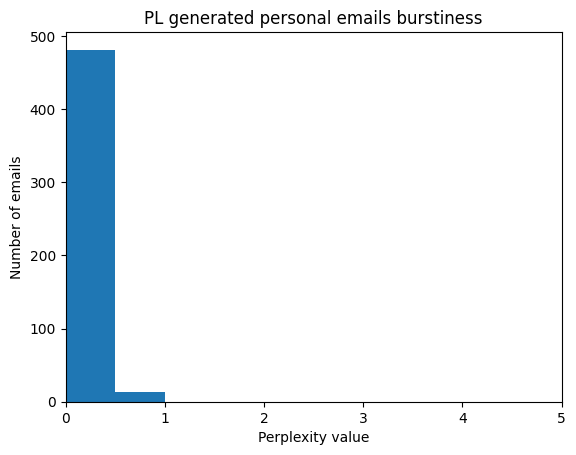

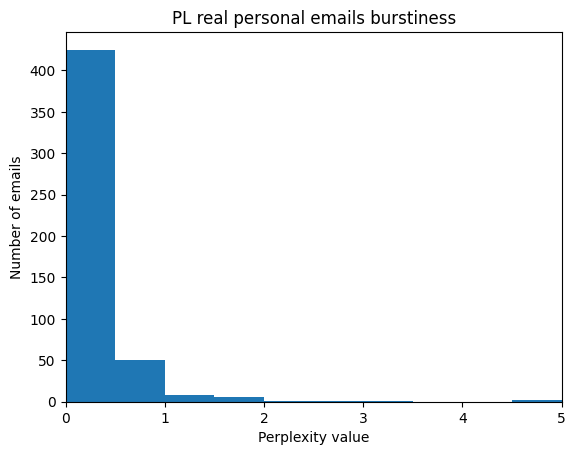

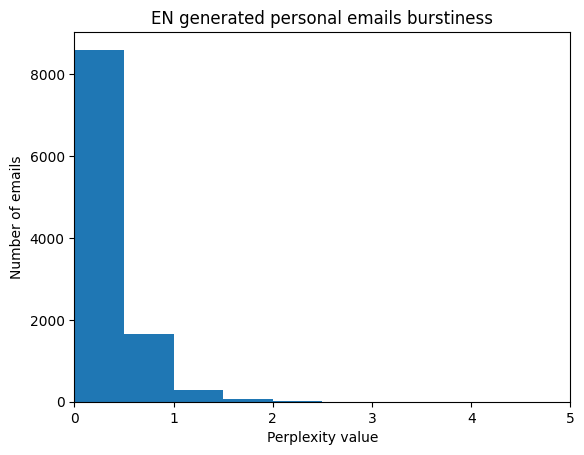

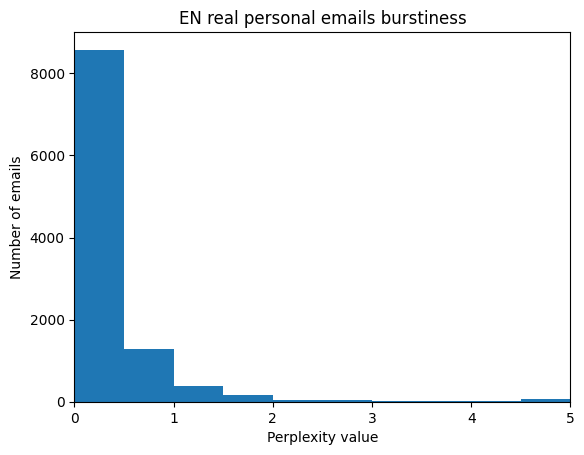

In [17]:
hist_attribute([attribute.burstiness for attribute in pl_generated_personal], 'PL generated personal emails burstiness', min_value=0, metric_name="Burstiness")
hist_attribute([attribute.burstiness for attribute in pl_real_personal], 'PL real personal emails burstiness', min_value=0, metric_name="Burstiness")
hist_attribute([attribute.burstiness for attribute in en_generated_personal], 'EN generated personal emails burstiness', min_value=0, metric_name="Burstiness")
hist_attribute([attribute.burstiness for attribute in en_real_personal], 'EN real personal emails burstiness', min_value=0, metric_name="Burstiness")

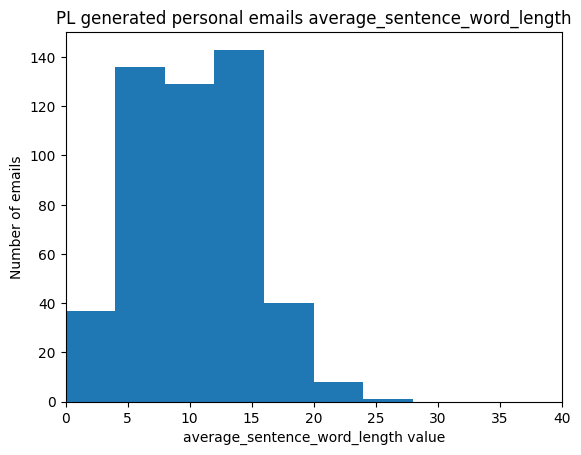

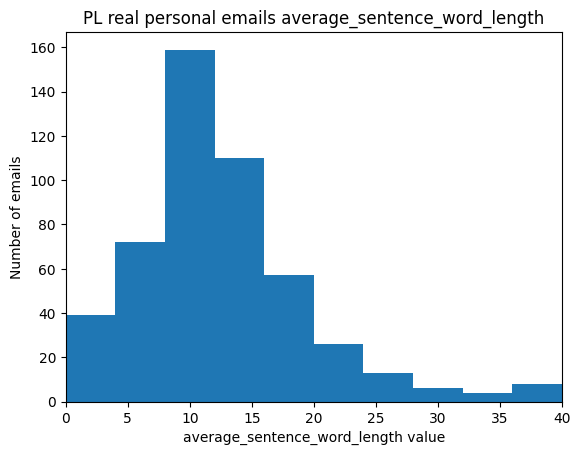

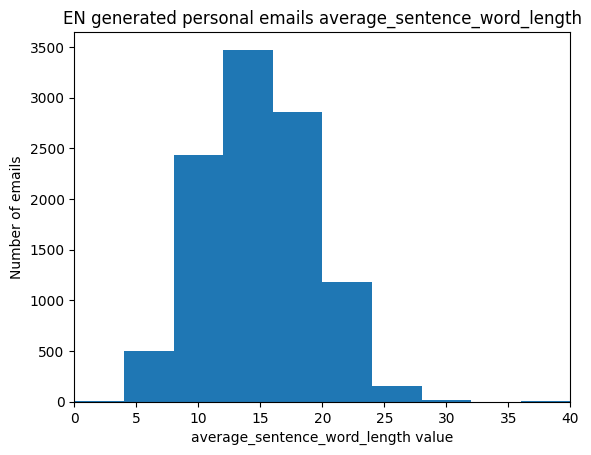

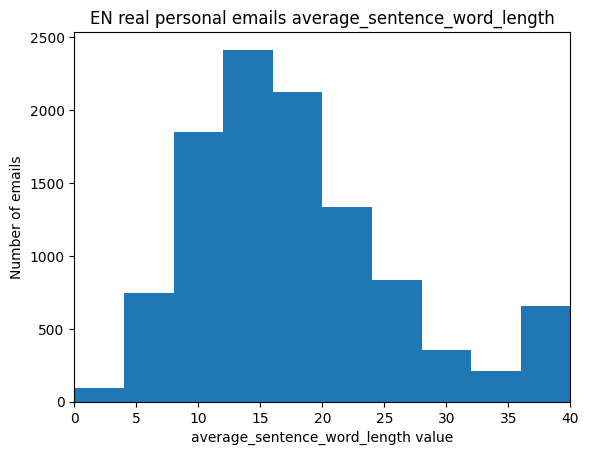

In [33]:
min_value = 0
max_value = 40
metric_name = "average_sentence_word_length" 
hist_attribute([attribute.average_sentence_word_length for attribute in pl_generated_personal], 'PL generated personal emails average_sentence_word_length', min_value=min_value, max_value=max_value, metric_name=metric_name)
hist_attribute([attribute.average_sentence_word_length for attribute in pl_real_personal], 'PL real personal emails average_sentence_word_length', min_value=min_value, max_value=max_value, metric_name=metric_name)
hist_attribute([attribute.average_sentence_word_length for attribute in en_generated_personal], 'EN generated personal emails average_sentence_word_length', min_value=min_value, max_value=max_value, metric_name=metric_name)
hist_attribute([attribute.average_sentence_word_length for attribute in en_real_personal], 'EN real personal emails average_sentence_word_length', min_value=min_value, max_value=max_value, metric_name=metric_name)

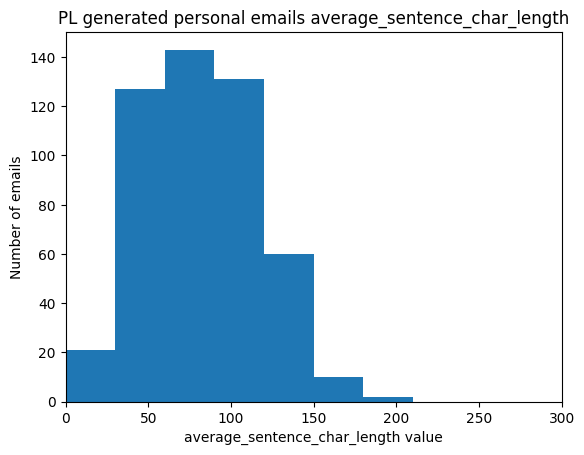

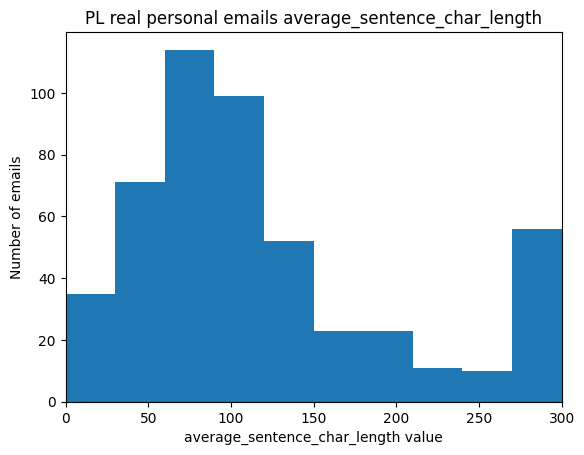

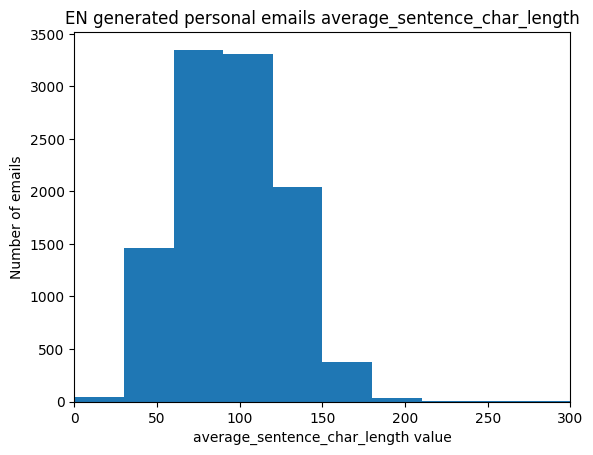

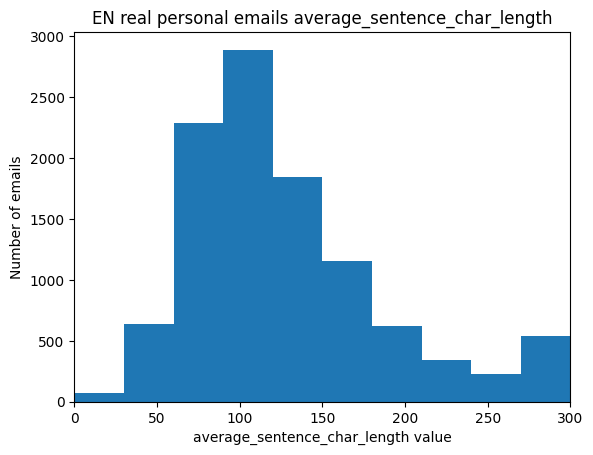

In [35]:
min_value = 0
max_value = 300
metric_name = "average_sentence_char_length" 
hist_attribute([attribute.average_sentence_char_length for attribute in pl_generated_personal], 'PL generated personal emails average_sentence_char_length', min_value=min_value, max_value=max_value, metric_name=metric_name)
hist_attribute([attribute.average_sentence_char_length for attribute in pl_real_personal], 'PL real personal emails average_sentence_char_length', min_value=min_value, max_value=max_value, metric_name=metric_name)
hist_attribute([attribute.average_sentence_char_length for attribute in en_generated_personal], 'EN generated personal emails average_sentence_char_length', min_value=min_value, max_value=max_value, metric_name=metric_name)
hist_attribute([attribute.average_sentence_char_length for attribute in en_real_personal], 'EN real personal emails average_sentence_char_length', min_value=min_value, max_value=max_value, metric_name=metric_name)

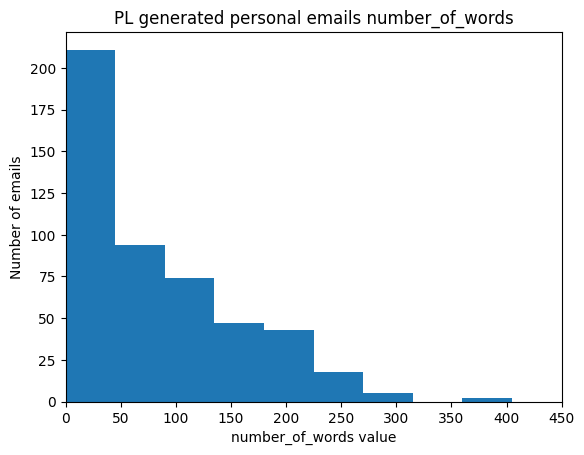

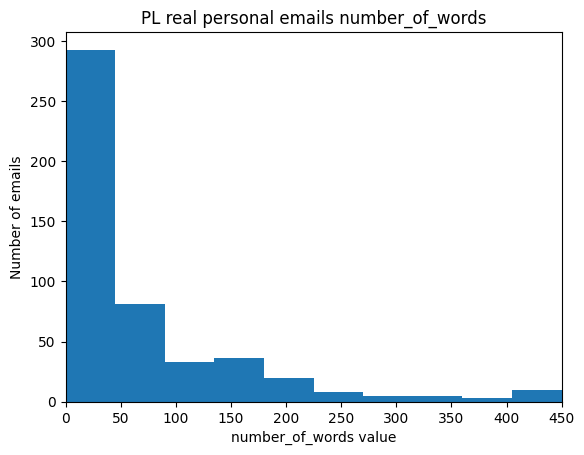

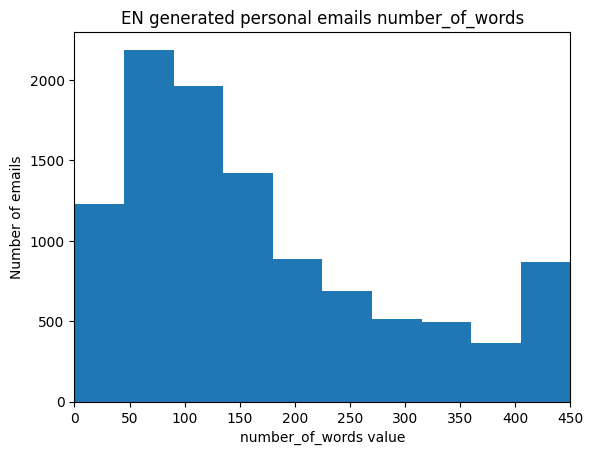

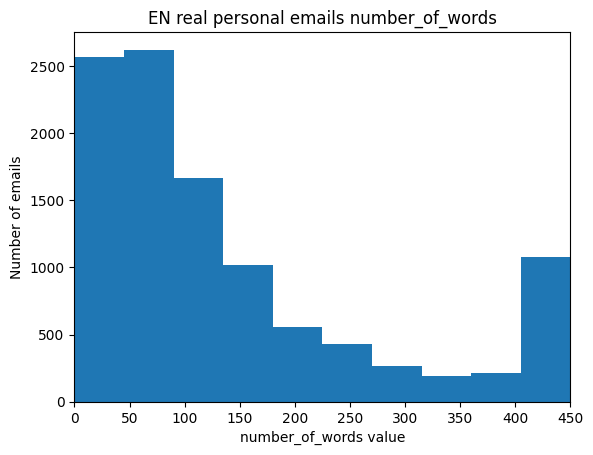

In [40]:
min_value = 0
max_value = 450
metric_name = "number_of_words" 
hist_attribute([attribute.number_of_words for attribute in pl_generated_personal], 'PL generated personal emails number_of_words', min_value=min_value, max_value=max_value, metric_name=metric_name)
hist_attribute([attribute.number_of_words for attribute in pl_real_personal], 'PL real personal emails number_of_words', min_value=min_value, max_value=max_value, metric_name=metric_name)
hist_attribute([attribute.number_of_words for attribute in en_generated_personal], 'EN generated personal emails number_of_words', min_value=min_value, max_value=max_value, metric_name=metric_name)
hist_attribute([attribute.number_of_words for attribute in en_real_personal], 'EN real personal emails number_of_words', min_value=min_value, max_value=max_value, metric_name=metric_name)

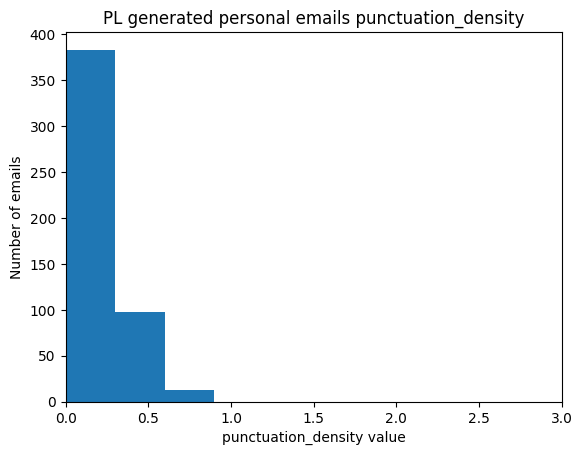

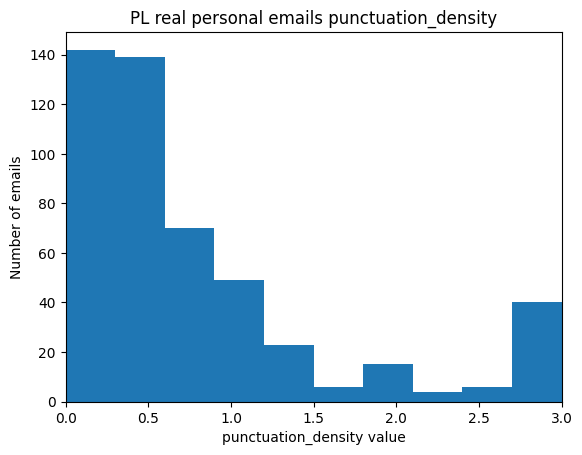

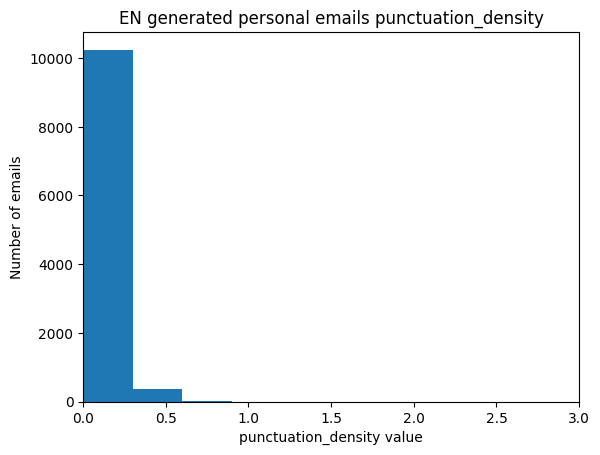

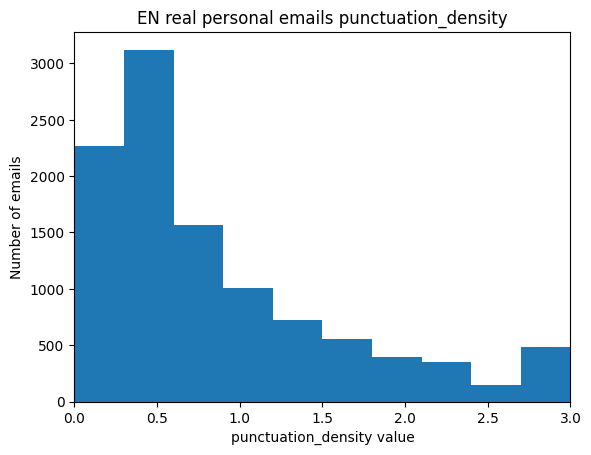

In [6]:
min_value = 0
max_value = 3
metric_name = "punctuation_density" 
hist_attribute([attribute.punctuation_density for attribute in pl_generated_personal], 'PL generated personal emails punctuation_density', min_value=min_value, max_value=max_value, metric_name=metric_name)
hist_attribute([attribute.punctuation_density for attribute in pl_real_personal], 'PL real personal emails punctuation_density', min_value=min_value, max_value=max_value, metric_name=metric_name)
hist_attribute([attribute.punctuation_density for attribute in en_generated_personal], 'EN generated personal emails punctuation_density', min_value=min_value, max_value=max_value, metric_name=metric_name)
hist_attribute([attribute.punctuation_density for attribute in en_real_personal], 'EN real personal emails punctuation_density', min_value=min_value, max_value=max_value, metric_name=metric_name)

In [ ]:
min_value = 0
max_value = 3
metric_name = "punctuation_per_sentence" 
hist_attribute([attribute.punctuation_density for attribute in pl_generated_personal], 'PL generated personal emails punctuation_density', min_value=min_value, max_value=max_value, metric_name=metric_name)
hist_attribute([attribute.punctuation_density for attribute in pl_real_personal], 'PL real personal emails punctuation_density', min_value=min_value, max_value=max_value, metric_name=metric_name)
hist_attribute([attribute.punctuation_density for attribute in en_generated_personal], 'EN generated personal emails punctuation_density', min_value=min_value, max_value=max_value, metric_name=metric_name)
hist_attribute([attribute.punctuation_density for attribute in en_real_personal], 'EN real personal emails punctuation_density', min_value=min_value, max_value=max_value, metric_name=metric_name)